In [10]:
import sys
import os

# 添加项目根目录到 sys.path
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)

print(project_root)

# 导入库
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

from core_model.optimizer import create_optimizer_scheduler
from core_model.custom_model import ClassifierWrapper, load_custom_model

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据预处理
transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761]
        ),
    ]
)

# 加载数据集
test_dataset = datasets.CIFAR100(
    root="./data", train=False, download=True, transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

train_dataset = datasets.CIFAR100(
    root="./data", train=True, download=True, transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=4)


# 定义特征提取器
def get_feature_extractor(model_name, num_classes, model_path, load_pretrained):
    print(f"model_name", model_name)
    print(f"model_path", model_path)

    model = load_custom_model(model_name, num_classes, load_pretrained)
    model = ClassifierWrapper(model, num_classes)
    model.load_state_dict(torch.load(model_path))

    model = model.to(device)
    model.eval()
    feature_extractor = nn.Sequential(*list(model.children())[:-1])
    feature_extractor = feature_extractor.to(device)
    feature_extractor.eval()
    return feature_extractor


# 加载模型
model_paths = {
    # "model_A": "../ckpt/cifar-100/nr_0.2_nt_asymmetric_balanced/step_0/contra/cifar-wideresnet40_teacher_restore.pth",
    "model_B": "../ckpt/cifar-100/nr_0.2_nt_asymmetric_balanced/step_0/contra/cifar-wideresnet40_worker_restore.pth",
    # "model_C": "./models/model_C.pth",
}

model_name = "cifar-wideresnet40"
num_classes = 100
load_pretrained = False

feature_extractors = {}
for key, model_path in model_paths.items():
    feature_extractors[key] = get_feature_extractor(
        model_name, num_classes, model_path, load_pretrained
    )


# 特征提取函数
def extract_features(feature_extractor, data_loader):
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in tqdm(data_loader):
            images = images.to(device)
            outputs = feature_extractor(images)
            outputs = outputs.view(outputs.size(0), -1)
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels


# 提取特征
gallery_features = {}
gallery_labels = {}
query_features = {}
query_labels = {}

for model_name, extractor in feature_extractors.items():
    print(f"Extracting features using {model_name}")
    g_features, g_labels = extract_features(extractor, train_loader)
    gallery_features[model_name] = g_features
    gallery_labels[model_name] = g_labels
    q_features, q_labels = extract_features(extractor, test_loader)
    query_features[model_name] = q_features
    query_labels[model_name] = q_labels


# 检索与评估
def retrieve(gallery_feats, query_feats, top_k=10):
    sims = cosine_similarity(query_feats, gallery_feats)
    indices = np.argsort(-sims, axis=1)[:, :top_k]
    return indices


def calculate_map(indices, gallery_labels, query_labels):
    num_queries = query_labels.shape[0]
    ap_list = []
    for i in range(num_queries):
        query_label = query_labels[i]
        retrieved_labels = gallery_labels[indices[i]]
        relevant = (retrieved_labels == query_label).astype(int)
        num_relevant = relevant.sum()
        if num_relevant == 0:
            ap_list.append(0)
            continue
        cumulative_precision = np.cumsum(relevant) / (np.arange(len(relevant)) + 1)
        ap = (cumulative_precision * relevant).sum() / num_relevant
        ap_list.append(ap)
    mAP = np.mean(ap_list)
    return mAP


# 评估模型
top_k = 10
results = {}

for model_name in feature_extractors.keys():
    print(f"Evaluating {model_name}")
    indices = retrieve(
        gallery_features[model_name], query_features[model_name], top_k=top_k
    )
    mAP = calculate_map(indices, gallery_labels[model_name], query_labels[model_name])
    results[model_name] = mAP
    print(f"{model_name} mAP: {mAP:.4f}")

# 输出结果
for model_name, mAP in results.items():
    print(f"Model: {model_name}, mAP: {mAP:.4f}")

/nvme/szh/code/tta-mr
Files already downloaded and verified
Files already downloaded and verified
model_name cifar-wideresnet40
model_path ../ckpt/cifar-100/nr_0.2_nt_asymmetric_balanced/step_0/contra/cifar-wideresnet40_worker_restore.pth


/tmp/ipykernel_218442/1132843989.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Extracting features using model_B


100%|██████████| 79/79 [00:02<00:00, 28.80it/s]


Evaluating model_B
model_B mAP: 0.3920
Model: model_B, mAP: 0.3920


Files already downloaded and verified
Files already downloaded and verified
model_name: cifar-wideresnet40
model_path: ../ckpt/cifar-100/nr_0.2_nt_asymmetric_balanced/step_0/contra/cifar-wideresnet40_worker_restore.pth


/tmp/ipykernel_218442/3455849051.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Extracting features using model_B


100%|██████████| 79/79 [00:03<00:00, 25.83it/s]


Evaluating model_B


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


model_B mAP: 0.4073
Model: model_B, mAP: 0.4073


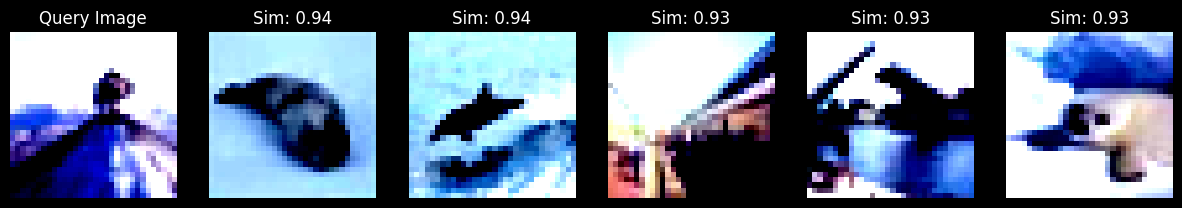

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


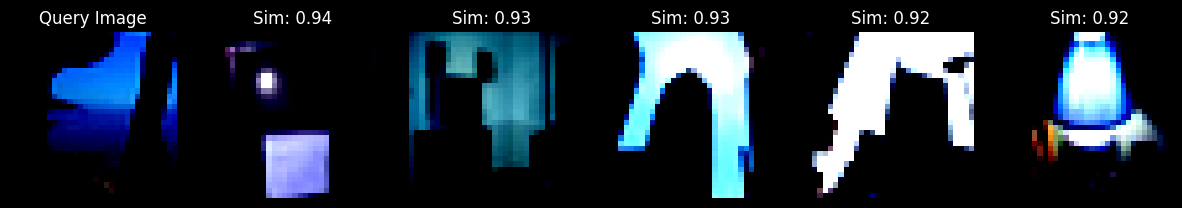

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


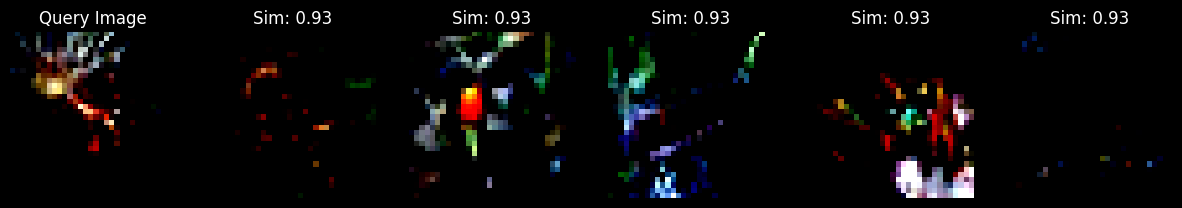

In [11]:
# 导入库
import sys
import os

# 添加项目根目录到 sys.path
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# 导入自定义模块
from core_model.optimizer import create_optimizer_scheduler
from core_model.custom_model import ClassifierWrapper, load_custom_model

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据预处理
transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761]
        ),
    ]
)

# 加载数据集
test_dataset = datasets.CIFAR100(
    root="./data", train=False, download=True, transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

train_dataset = datasets.CIFAR100(
    root="./data", train=True, download=True, transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=4)

# 定义特征提取器
def get_feature_extractor(model_name, num_classes, model_path, load_pretrained):
    print(f"model_name: {model_name}")
    print(f"model_path: {model_path}")

    # 加载模型
    model = load_custom_model(model_name, num_classes, load_pretrained)
    model = ClassifierWrapper(model, num_classes)
    # 加载模型权重
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()

    # 获取特征提取器
    feature_extractor = nn.Sequential(*list(model.children())[:-1])
    feature_extractor = feature_extractor.to(device)
    feature_extractor.eval()
    return feature_extractor

# 加载模型
model_paths = {
    "model_B": "../ckpt/cifar-100/nr_0.2_nt_asymmetric_balanced/step_0/contra/cifar-wideresnet40_worker_restore.pth",
}

model_name = "cifar-wideresnet40"
num_classes = 100
load_pretrained = False

feature_extractors = {}
for key, model_path in model_paths.items():
    feature_extractors[key] = get_feature_extractor(
        model_name, num_classes, model_path, load_pretrained
    )

# 特征提取函数
def extract_features(feature_extractor, data_loader):
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in tqdm(data_loader):
            images = images.to(device)
            outputs = feature_extractor(images)
            outputs = outputs.view(outputs.size(0), -1)
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

# 提取特征
gallery_features = {}
gallery_labels = {}
query_features = {}
query_labels = {}

for model_key, extractor in feature_extractors.items():
    print(f"Extracting features using {model_key}")
    g_features, g_labels = extract_features(extractor, train_loader)
    gallery_features[model_key] = g_features
    gallery_labels[model_key] = g_labels
    q_features, q_labels = extract_features(extractor, test_loader)
    query_features[model_key] = q_features
    query_labels[model_key] = q_labels

# 检索与评估
def retrieve(gallery_feats, query_feats, top_k=10):
    sims = cosine_similarity(query_feats, gallery_feats)
    indices = np.argsort(-sims, axis=1)[:, :top_k]
    sim_scores = np.take_along_axis(sims, indices, axis=1)
    return indices, sim_scores

def calculate_map(indices, gallery_labels, query_labels):
    num_queries = query_labels.shape[0]
    ap_list = []
    for i in range(num_queries):
        query_label = query_labels[i]
        retrieved_labels = gallery_labels[indices[i]]
        relevant = (retrieved_labels == query_label).astype(int)
        num_relevant = relevant.sum()
        if num_relevant == 0:
            ap_list.append(0)
            continue
        cumulative_precision = np.cumsum(relevant) / (np.arange(len(relevant)) + 1)
        ap = (cumulative_precision * relevant).sum() / num_relevant
        ap_list.append(ap)
    mAP = np.mean(ap_list)
    return mAP

# 评估模型
top_k = 5  # 设置需要展示的检索结果数量
results = {}

for model_key in feature_extractors.keys():
    print(f"Evaluating {model_key}")
    indices, sim_scores = retrieve(
        gallery_features[model_key], query_features[model_key], top_k=top_k
    )
    mAP = calculate_map(indices, gallery_labels[model_key], query_labels[model_key])
    results[model_key] = {'mAP': mAP, 'indices': indices, 'sim_scores': sim_scores}
    print(f"{model_key} mAP: {mAP:.4f}")

# 输出结果
for model_key, result in results.items():
    print(f"Model: {model_key}, mAP: {result['mAP']:.4f}")

# 可视化函数
def display_image_grid(query_dataset, gallery_dataset, query_index, retrieved_indices, sim_scores, save_path=None):
    K = len(retrieved_indices)
    fig, axs = plt.subplots(1, K + 1, figsize=(15, 5))
    # 显示查询图像
    query_img, _ = query_dataset[query_index]
    axs[0].imshow(np.transpose(query_img.numpy(), (1, 2, 0)))
    axs[0].set_title("Query Image")
    axs[0].axis('off')

    # 显示检索结果
    for i, idx in enumerate(retrieved_indices):
        img, _ = gallery_dataset[idx]
        axs[i + 1].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axs[i + 1].set_title(f"Sim: {sim_scores[i]:.2f}")
        axs[i + 1].axis('off')

    if save_path:
        plt.savefig(save_path)
    plt.show()

# 对于指定的查询图像进行可视化
model_key = list(feature_extractors.keys())[0]  # 选择模型
query_indices = [0, 10, 100]  # 指定要展示的查询图像索引

for query_idx in query_indices:
    retrieved_indices = results[model_key]['indices'][query_idx]
    sim_scores = results[model_key]['sim_scores'][query_idx]
    display_image_grid(
        test_dataset, train_dataset,
        query_idx, retrieved_indices, sim_scores,
        save_path=None  # 如果需要保存图像，设置保存路径
    )
